# Spherical Harmonics correlation analysis

The pyanalisi library code is hosted at https://github.com/rikigigi/analisi
In the following I load a NVE trajectory of a 2x2x2 supercell of NH$_3$ superionic system with 128 total atoms (32 NH$_3$ molecules). The trajectory is loaded from my aiida database. The simulation is performed at 950K and 70GPa.

### Calculation procedure:
The implemented formula for the real spherical harmonics is the following:
$$
Y_{\ell m} =
\begin{cases}
 \displaystyle (-1)^m\sqrt{2} \sqrt{{2\ell+1 \over 4\pi}{(\ell-|m|)!\over (\ell+|m|)!}} \ 
 P_\ell^{|m|}(\cos \theta) \ \sin( |m|\varphi )  
 &\mbox{if } m<0 
 \\
 \displaystyle \sqrt{{ 2\ell+1 \over 4\pi}} \ P_\ell^m(\cos \theta) 
 & \mbox{if } m=0 
 \\
 \displaystyle (-1)^m\sqrt{2} \sqrt{{2\ell+1 \over 4\pi}{(\ell-m)!\over (\ell+m)!}} \ 
 P_\ell^m(\cos \theta) \ \cos( m\varphi )
 & \mbox{if } m>0 \,.
\end{cases}
$$
Where $\cos \theta$, $\sin \varphi$, $\cos \varphi$ are calculated using cartesian components:
$$
\cos \theta = \frac{z}{\sqrt{x^2+y^2+z^2}}  \\
\cos \varphi = \frac{x}{\sqrt{x^2+y^2}}  \\ 
\sin \varphi = \frac{y}{\sqrt{x^2+y^2}} \\
$$
and $\sin |m|\varphi$, $\cos |m|\varphi$ are evaluated using Chebyshev polynomials with a recursive definition:
$$
\begin{cases}
\cos m \varphi &= 2 \cos (m-1)\varphi \cos \varphi - \cos (m-2)\varphi \\
\sin m \varphi &= 2 \cos \varphi \sin (m-1)\varphi - \sin (m-2)\varphi \\
\end{cases}
$$
and $P_\ell^m$ are the associated Legendre polynomials, calculated with the following set of recursive definition:
$$
P_{\ell +1}^{\ell +1}(x) = - (2\ell+1) \sqrt{1-x^2} P_{\ell}^{\ell}(x) \\
P_{\ell +1}^{\ell}(x) = x (2\ell+1) P_{\ell}^{\ell}(x) \\
$$
that allows us to calculate every $(\ell,\ell)$ and every $(\ell,\ell+1)$ element of the $(\ell,m)$ values. Then we have the recursion to go up in $\ell$, for any value of it:
$$
P^m_{\ell} = \frac{x(2\ell - 1)P^m_{\ell-1} - (\ell + m - 1)P^m_{\ell-2}}{\ell - m}
$$

The program, given a number $\ell_{max}$ and a triplet $(x,y,z)$, is able to calculate every value of $Y_{\ell m}(x,y,z) \forall \ell \in [0,\ell_{max}]$ and for all allowed values of $m$ with a single recursion. Let
$$
y_{\ell m}^{I j}(t) = \int_{V_I} \mathrm{d}\theta\mathrm{d}\varphi\mathrm{d}r \rho^j(r,\theta,\varphi,t) Y_{\ell m}(\theta,\varphi)
$$
for some timestep $t$ in some volume $V_I$ taken as a the difference of two concentric spheres centered on the atom $I$ of radius $r_{inner}$ and $r_{outer}$, and where $\rho_j$ is the atomic density of the species $j$. Since the densities are taken as sums of dirac delta functions, it is sufficient to evaluate the spherical harmonics functions at the position of the atoms.
Then we calculate the following:
$$
c_\ell^{Jj}(t)=\langle \frac{1}{N_J}\sum_{I \text{ is of type } J}\sum_{m=-\ell}^{\ell} y_{\ell m}^{I j}(0) y_{\ell m}^{I j}(t) \rangle
$$
where $\langle \cdot \rangle$ is an average operator, and we do an additional average over all the $N_J$ central atoms of the type $J$. The $\langle \cdot \rangle$ average is implemented as an average over the starting timestep.

In [15]:
import numpy as np
import pyanalisi
filepath_tests = '/home/bertossa/analisi/tests'
pos = np.load(filepath_tests + '/data_NH3/positions.npy')  
vel = np.load(filepath_tests + '/data_NH3/velocities.npy') 
box = np.load(filepath_tests + '/data_NH3/cells.npy')      
times = np.load(filepath_tests + '/data_NH3/times.npy')      
types = np.zeros(pos.shape[1], dtype = np.int32)            
types[-32:]=1                                          
params= [pos, vel, types, box]
traj=pyanalisi.Trajectory(*params,True, False)

In [2]:
import matplotlib.pyplot as plt

In [16]:
print(pyanalisi.info())

cite as:
Riccardo Bertossa, analisi
https://github.com/rikigigi/analisi
(c) 2017-2020
COMPILED AT Jun 25 2020 16:57:20 by /usr/bin/g++-8 whith flags (Release) -std=c++17 -fopenmp -O3 -DNDEBUG -Ofast (Debug)  -std=c++17 -fopenmp -g -DEIGEN_INITIALIZE_MATRICES_BY_NAN     -fsanitize=address -fno-omit-frame-pointer  -fsanitize=leak -fsanitize=undefined (build type was Release) on a Linux-4.15.0-1087-oem whith processor x86_64
With python support: /usr/lib/x86_64-linux-gnu/libpython3.6m.so


we see that the N atoms stay more or less fixed

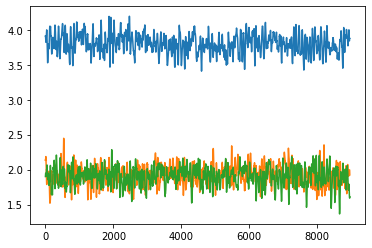

In [17]:
plt.plot(pos[60000:,-32,:])

while H atoms go around the cell:

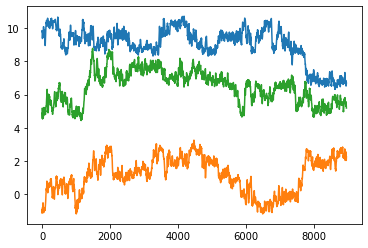

In [18]:
plt.plot(pos[60000:,-33,:])

In [7]:
pos.shape

(68958, 128, 3)

cell vectors:

In [8]:
box[0]

array([[7.62936044, 0.        , 0.        ],
       [0.        , 7.62936044, 0.        ],
       [0.        , 0.        , 7.62936044]])

## g(r) calculation

In [19]:
startr=0.5
endr=3.8
nbin=100
gofr=pyanalisi.Gofrt(traj,startr,endr,nbin,1,4,10,False)
gofr.reset(8900)

gofr.calculate(60000)

gr=np.array(gofr,copy=False)

In [20]:
gr.shape

(1, 6, 100)

In [21]:
dr=(endr-startr)/nbin

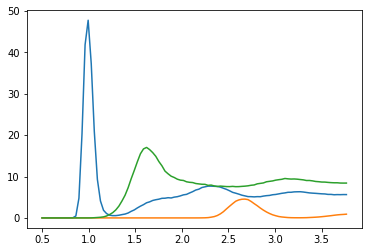

In [22]:
r=np.arange(gr.shape[-1])*dr+startr
for j in range(0,10,10):
    for i in range(0,gr.shape[1]//2):
        plt.plot(r,gr[j,i,:]/(r**2))

In [13]:
gr_old=np.load('gr.npy')

In [14]:
np.save('gr.npy',gr)

In [23]:
gr-gr_old

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

## spherical harmonics stuff

In [46]:
startr=0.7
endr=3.5
nbin=4
dr=(endr-startr)/nbin


test=pyanalisi.SphericalCorrelations(traj
                                     ,startr #minimum of radial distance
                                     ,endr #maximum of radial distance
                                     ,nbin # number of distance bins
                                     ,200 # maximum length of correlation functions in timesteps
                                     ,4 # number of threads
                                     ,90 # time skip to average over the trajectory
                                     ,False)
test.reset(8700) # number of timesteps to analyze
test.calculate(60000) #calculate starting at this timestep
res=np.array(test,copy=False) # get result


some plots:

In [89]:
res.shape

(200, 2, 2, 4, 11)

H-H correlations:

l=10: 0.39140544193064625
l=9: 0.35276151972897113
l=8: 0.3168046331243374
l=7: 0.277448767265524
l=6: 0.24165443661602476
l=5: 0.2047231997444632
l=4: 0.16959206482186606
l=3: 0.1303664903134601
l=2: 0.09013211569987196
l=1: 0.054033442527775775
l=0: 0.02141550082626125
l=10: 11.66708834062636
l=9: 10.824732414237626
l=8: 10.947772105775302
l=7: 10.898588161227037
l=6: 10.145429020237957
l=5: 7.5404456565125155
l=4: 4.152347685026668
l=3: 2.1526365063396096
l=2: 1.0080776571603325
l=1: 0.4591149741650654
l=0: 5.001997847418413
l=10: 20.35236155609934
l=9: 19.432098299160508
l=8: 15.567566673197023
l=7: 11.198733554412087
l=6: 7.834642989138411
l=5: 6.296837069401576
l=4: 4.8542215225440914
l=3: 3.732330412862539
l=2: 2.259541012088525
l=1: 1.1762741827043166
l=0: 8.733354040066223
l=10: 35.40648949664707
l=9: 28.032071569996923
l=8: 21.547479028348437
l=7: 16.288358995658996
l=6: 12.109299326613788
l=5: 9.393547548243916
l=4: 6.980614657306509
l=3: 5.524788162717747
l=2: 3.67578289439

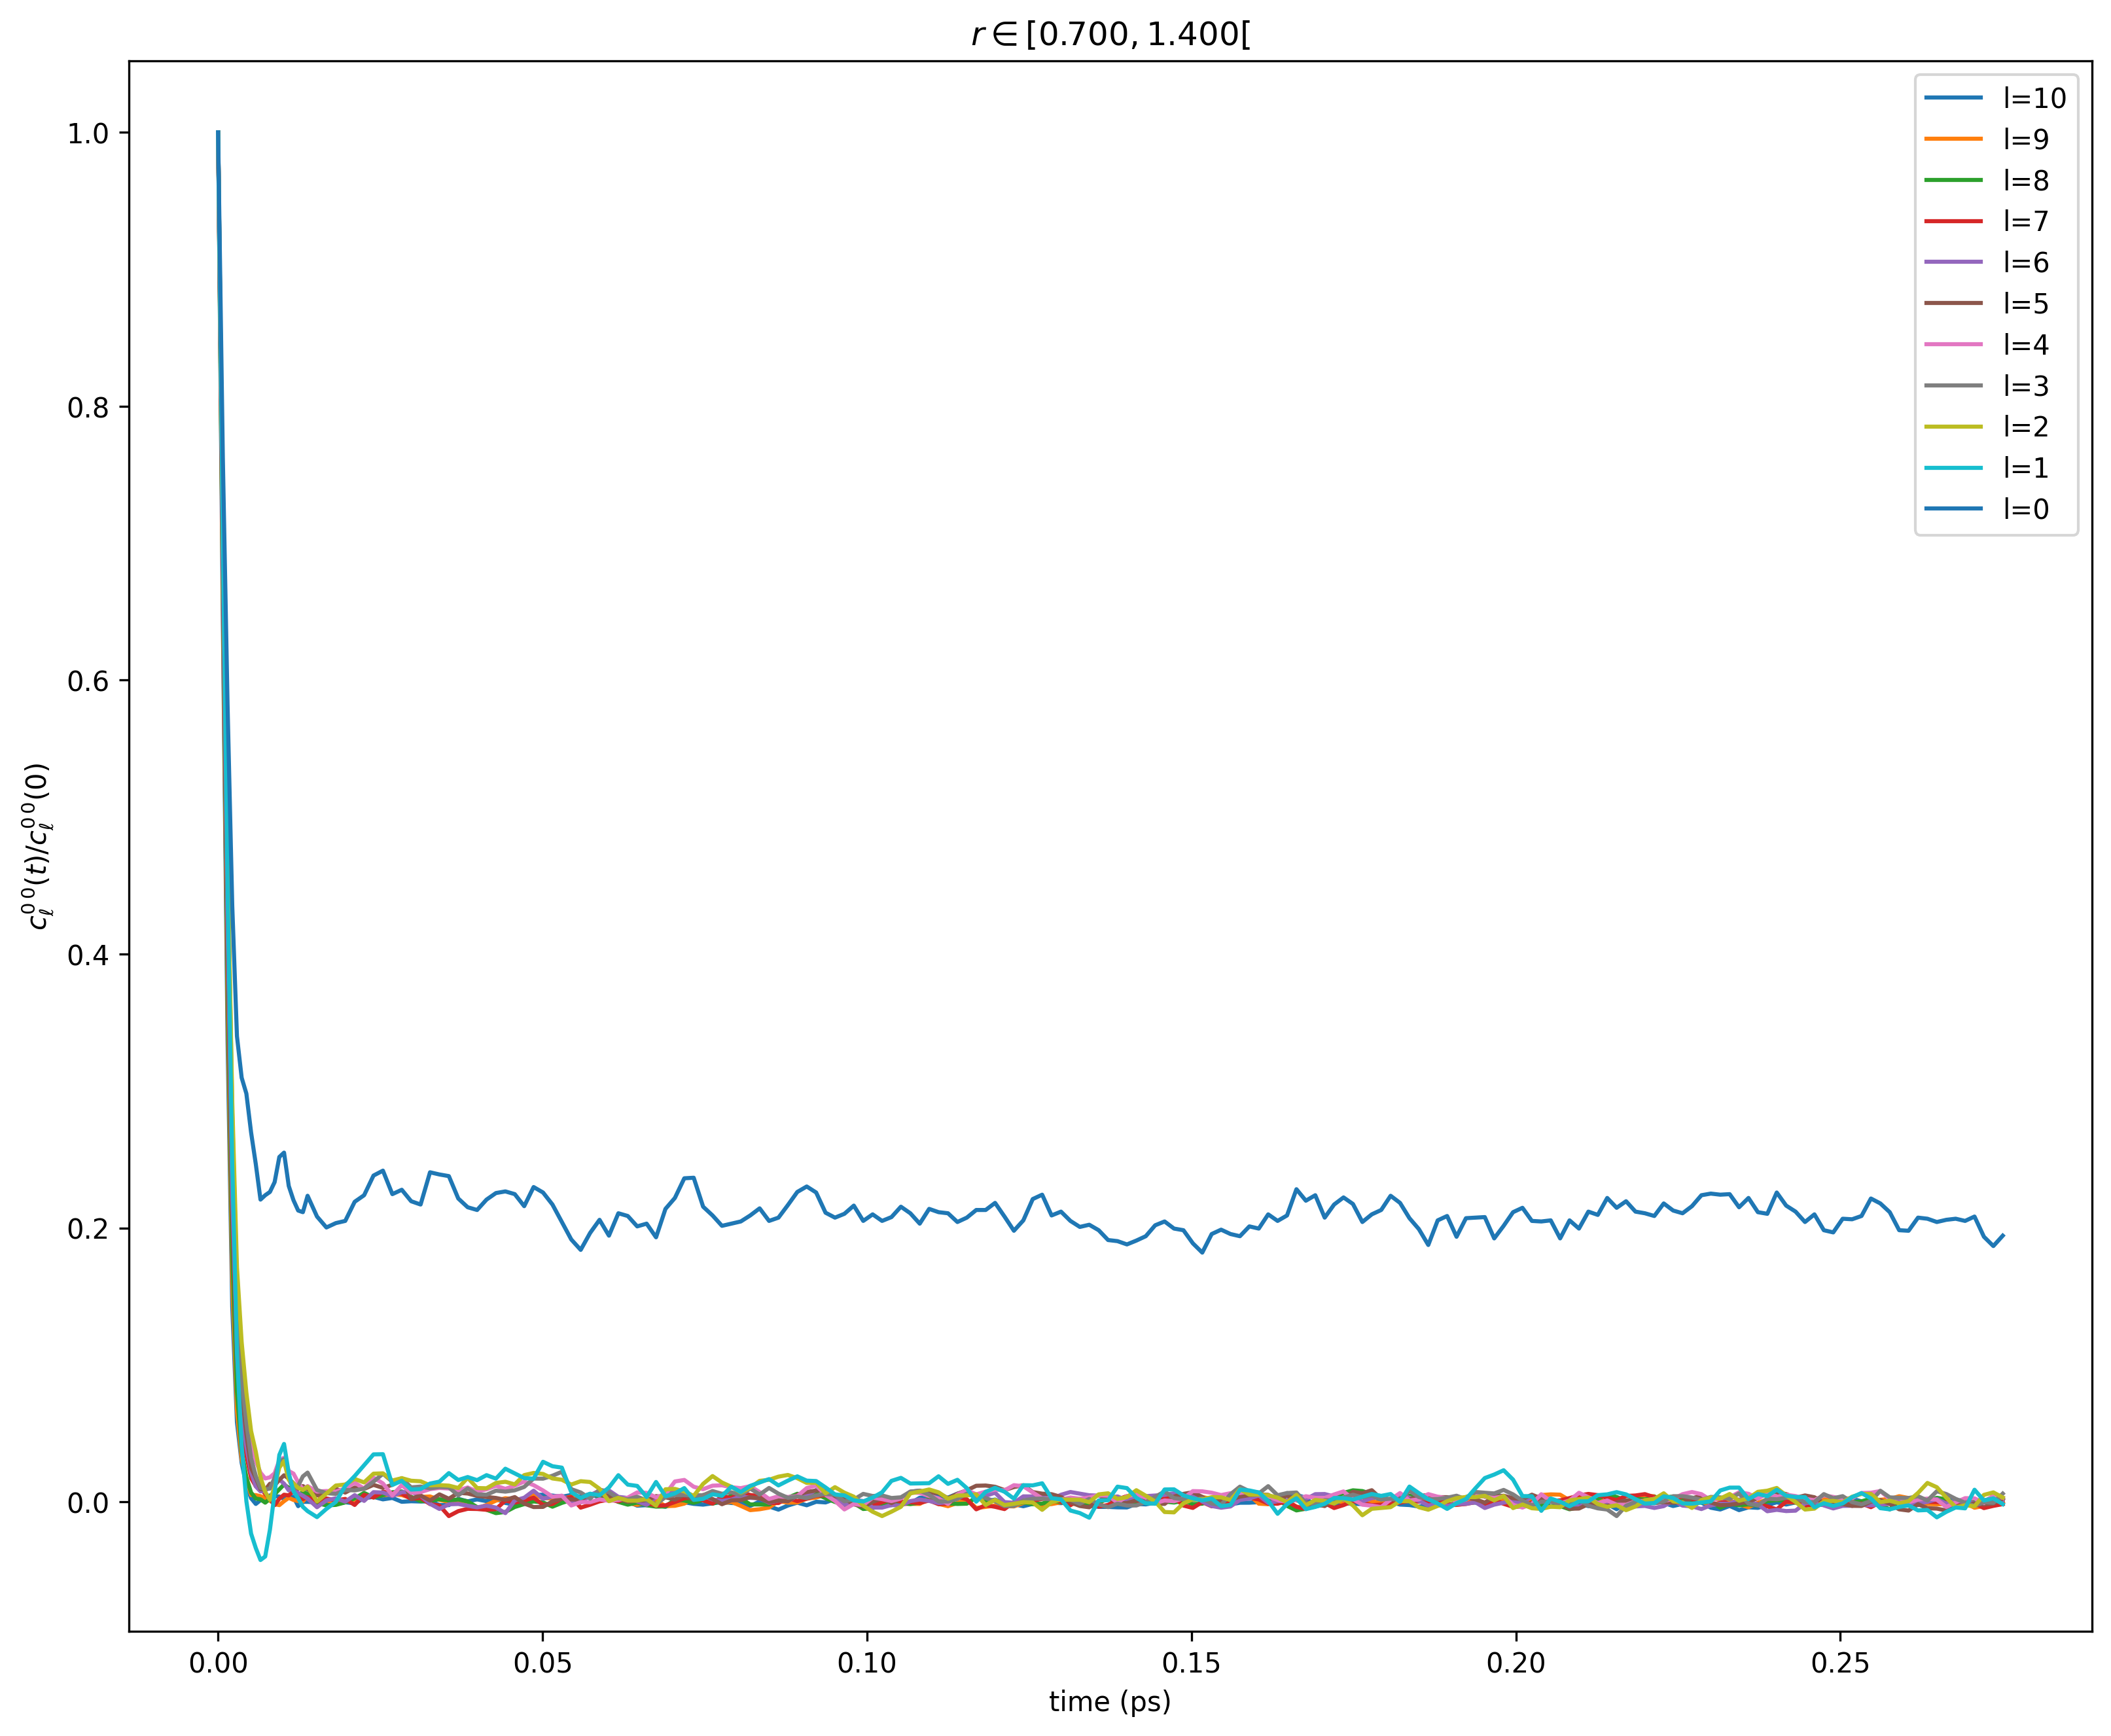

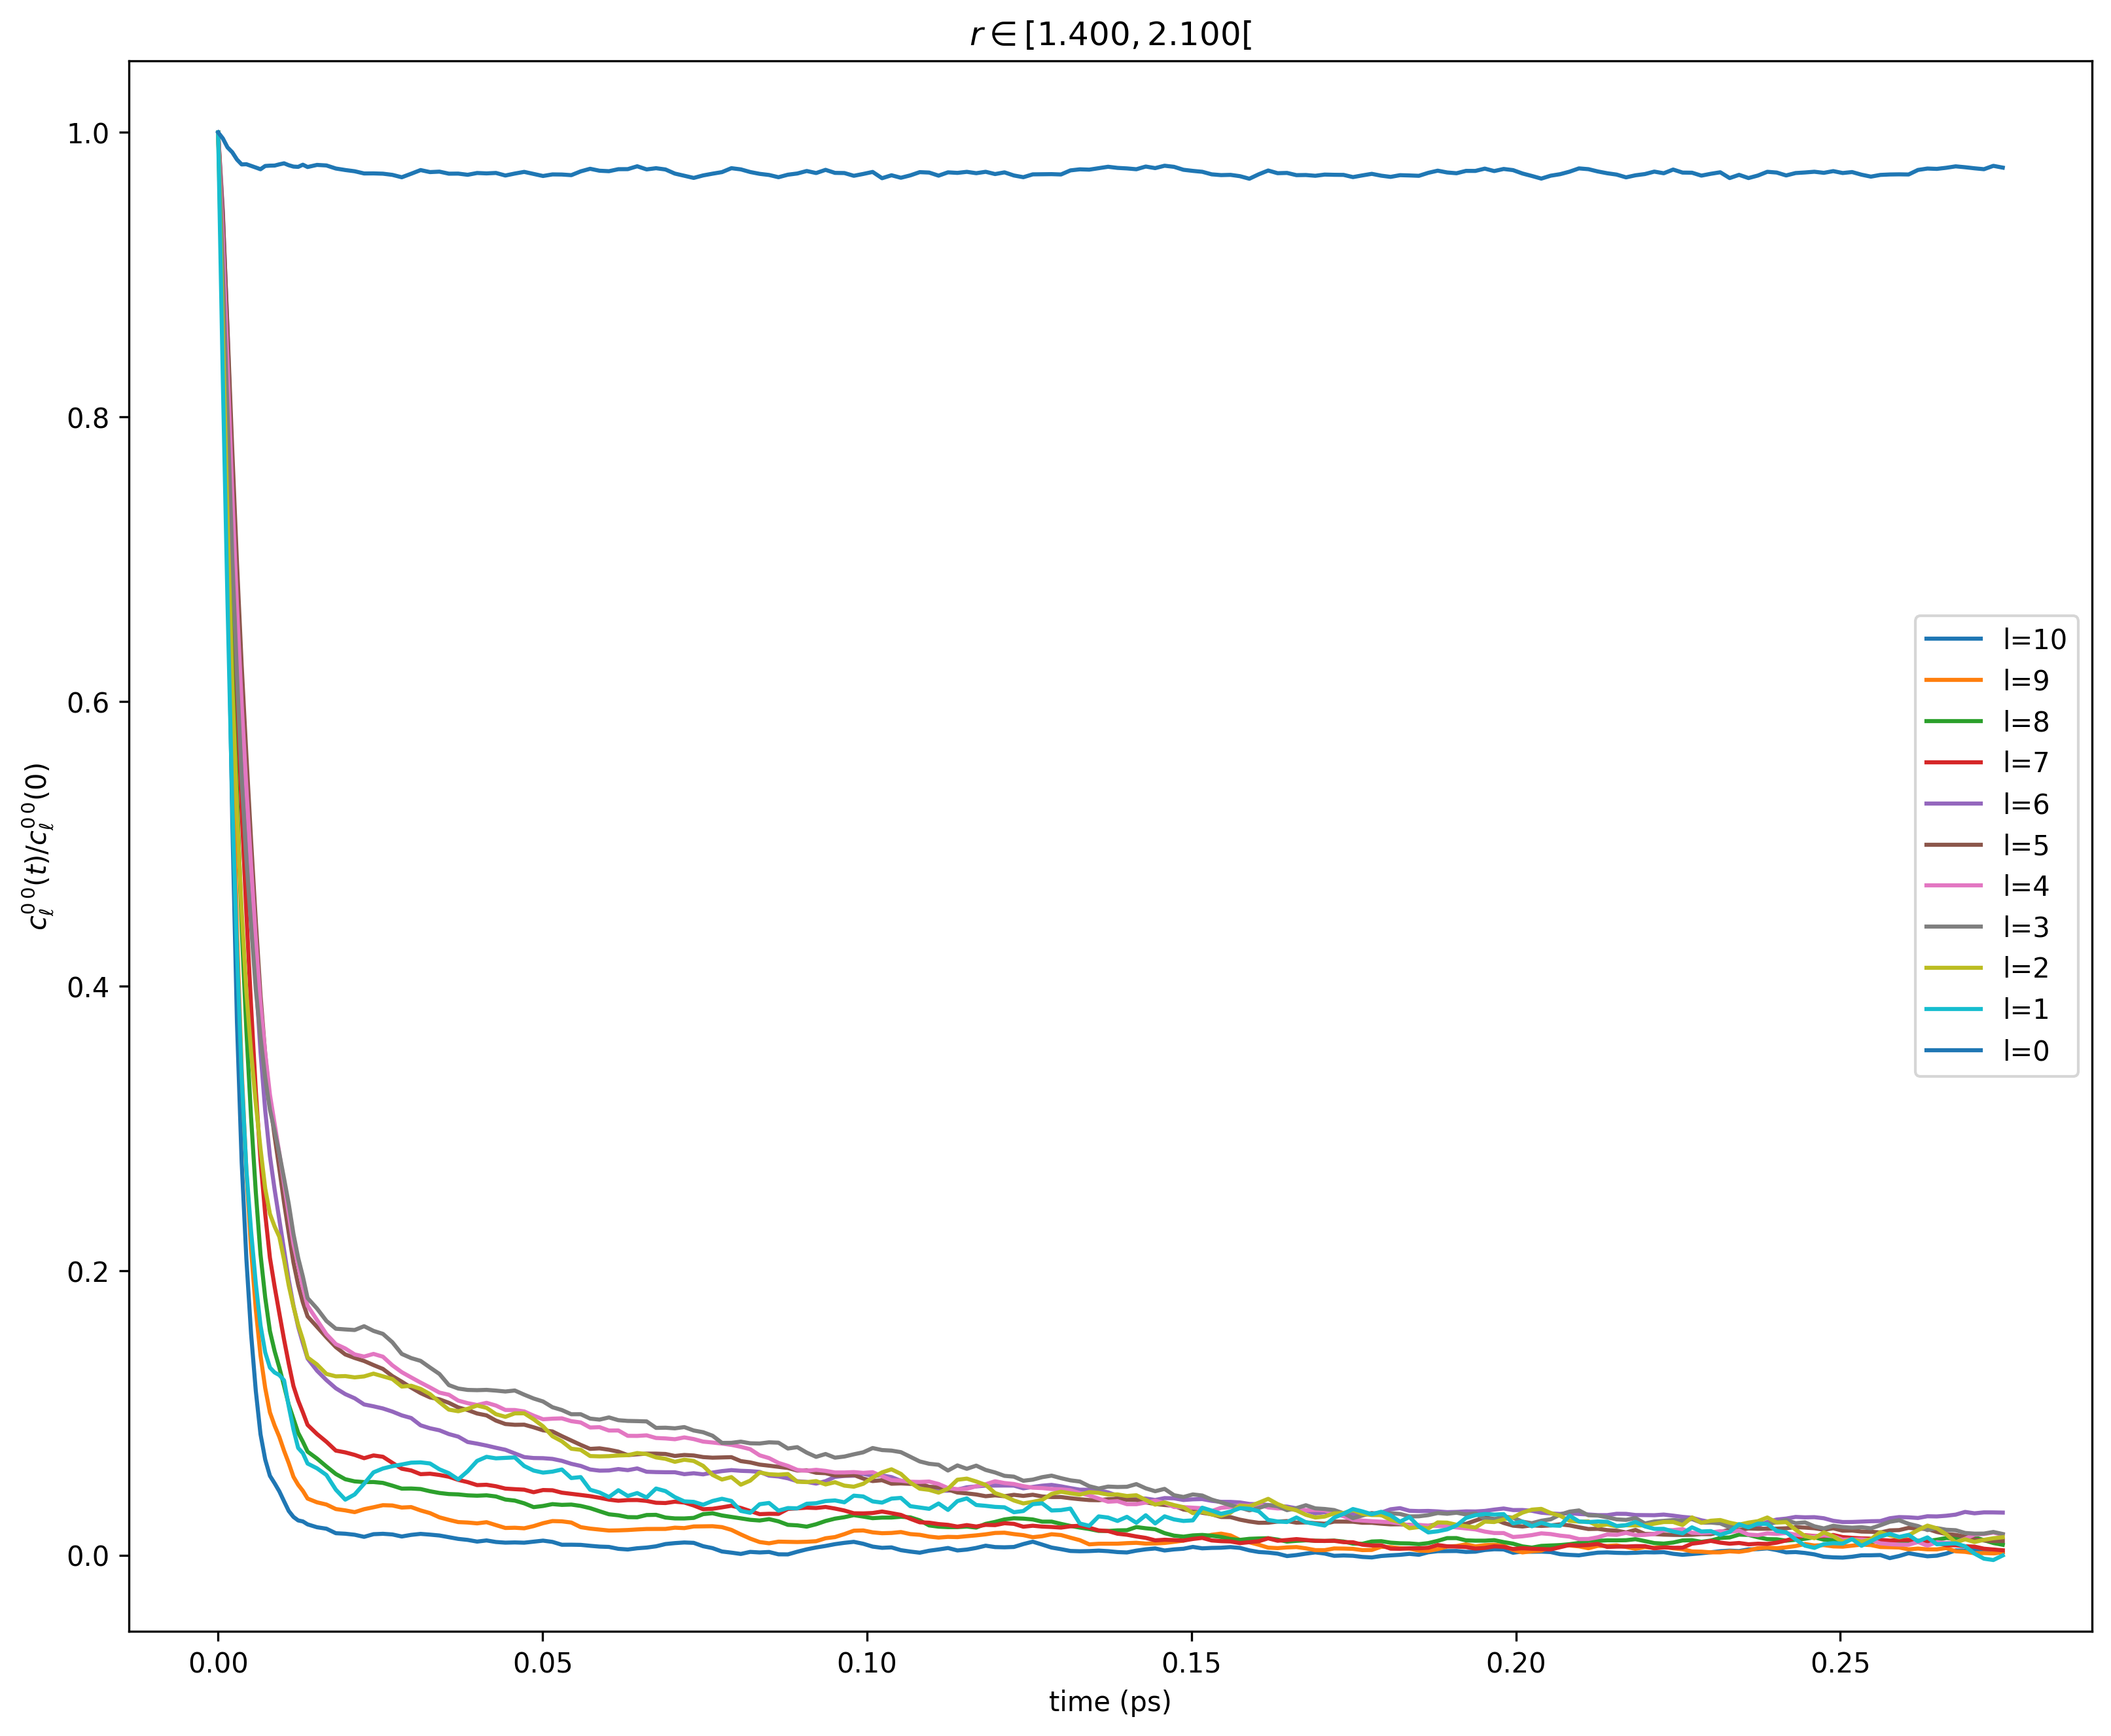

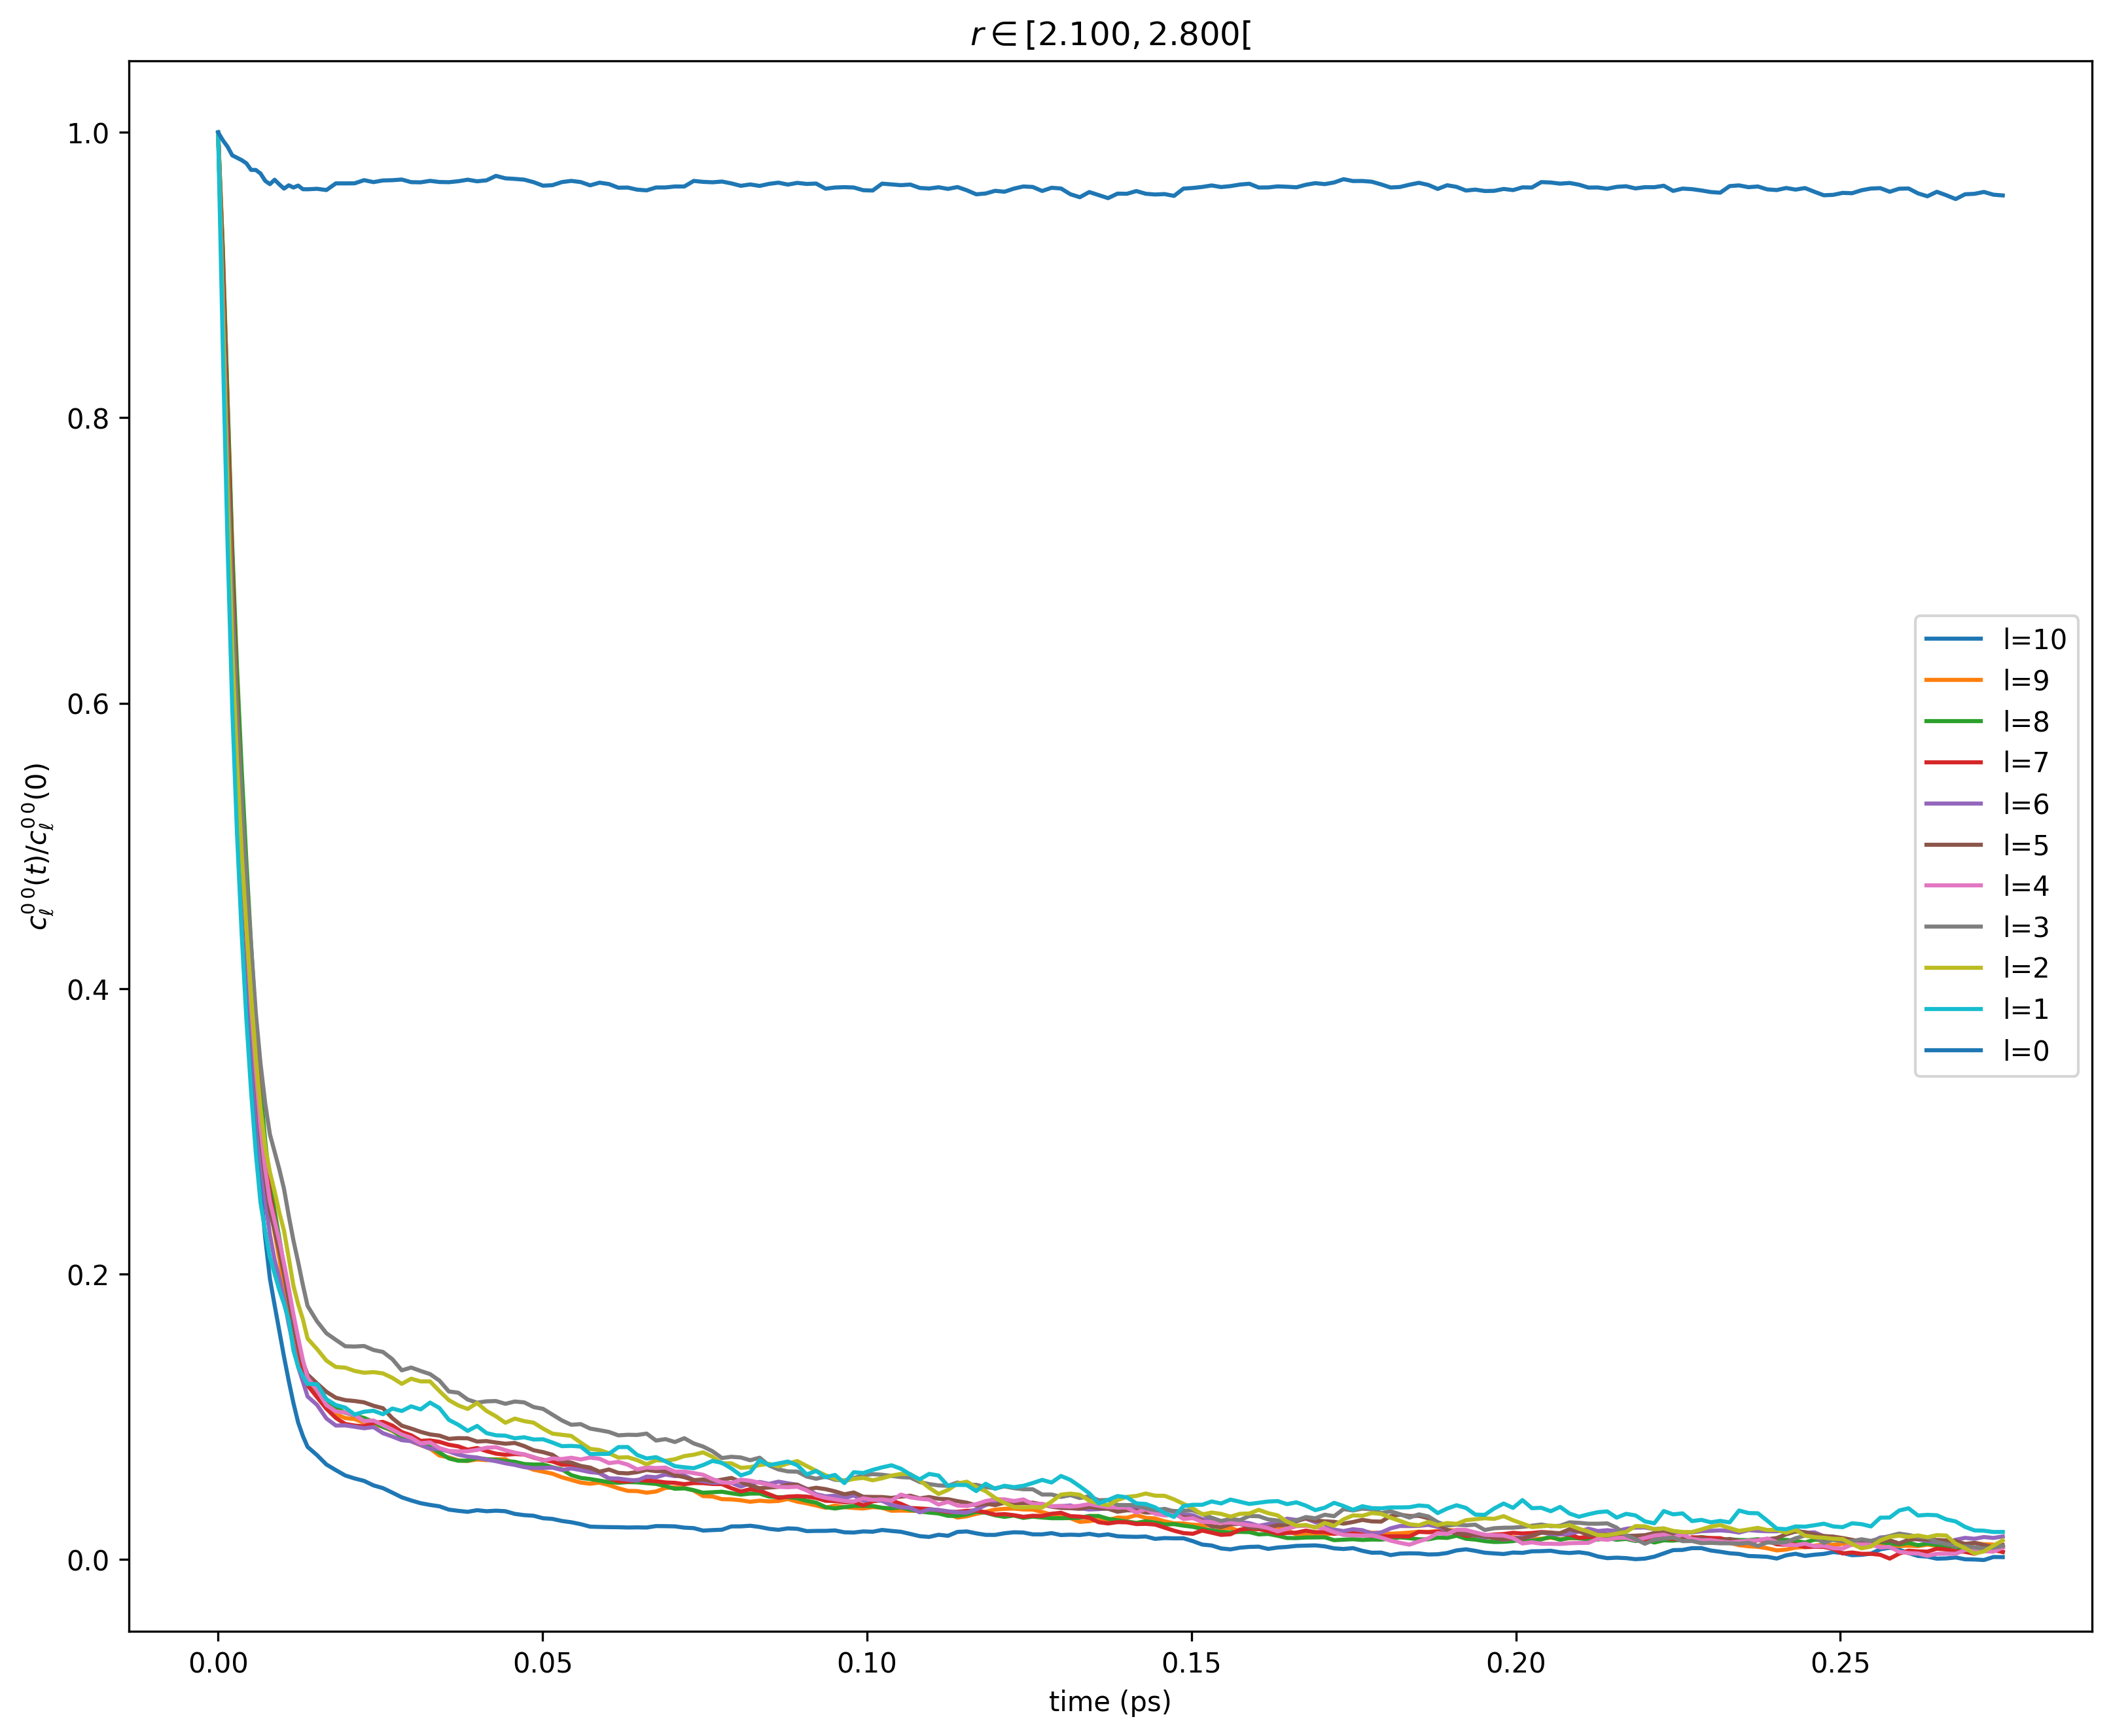

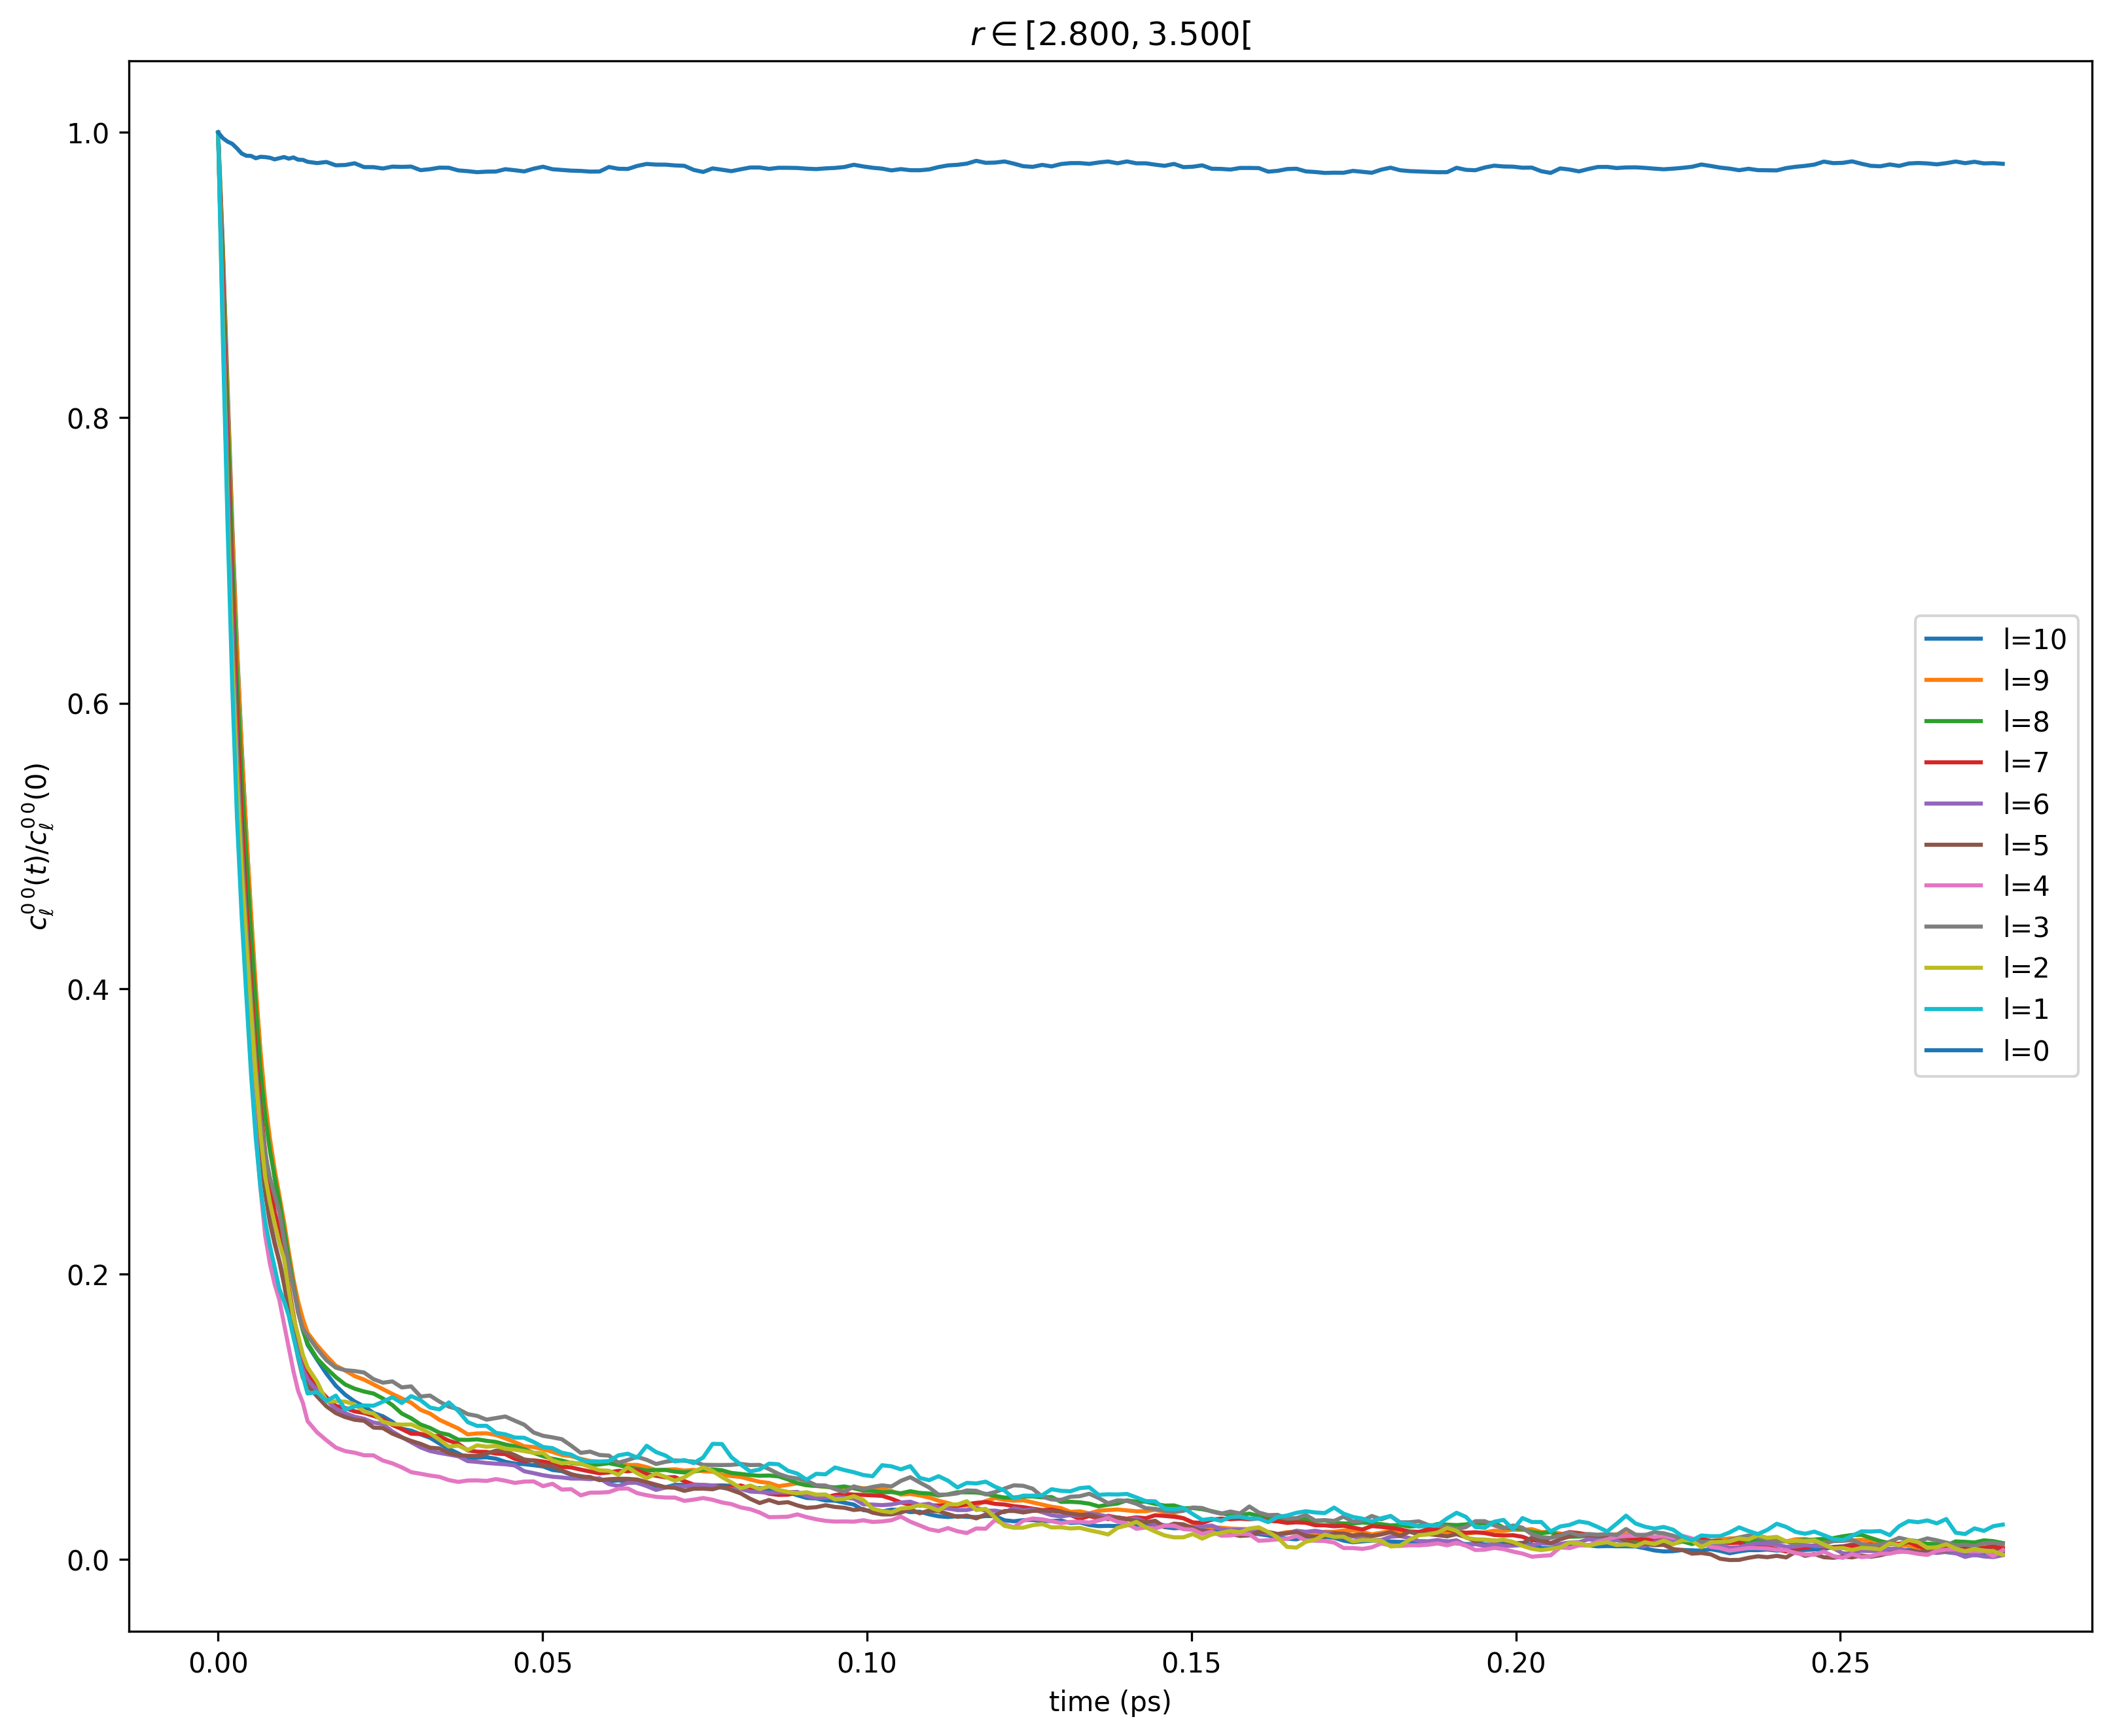

In [117]:
for i in range(0,4):
    plot(0,0,i,0,11)

N-N correlations

In [112]:
res.shape

(200, 2, 2, 4, 11)

In [114]:
def plot(type1,type2,ibin,lmin,lmax):
    fig,ax =plt.subplots(figsize=(10,8),dpi=300)
    ax=fig.add_axes([0,0,1,1])
    for i in range(lmin,lmax):
        print('l={}: {}'.format(10-i, res[0,type1,type2,ibin,i]))
        ax.plot(times[:res.shape[0]]-times[0],res[:,type1,type2,ibin,i]/res[0,type1,type2,ibin,i],label='l='+str(10-i))
    ax.legend()
    ax.set_title('$r \in [{:.3f} ,{:.3f}[$'.format(startr+dr*ibin,startr+dr*(ibin+1)))
    #ax.set_xlim([0,200])
    ax.set_xlabel('time (ps)')
    ax.set_ylabel('$c_{{\ell}}^{{{0}\,{1}}}(t)/c_{{\ell}}^{{{0}\,{1}}}(0)$'.format(type1,type2))

l=10: 6.575783844205737
l=9: 4.9568432937797615
l=8: 15.256777983621543
l=7: 5.460546704907
l=6: 23.97568683684811
l=5: 5.120308898445247
l=4: 3.5043884410908546


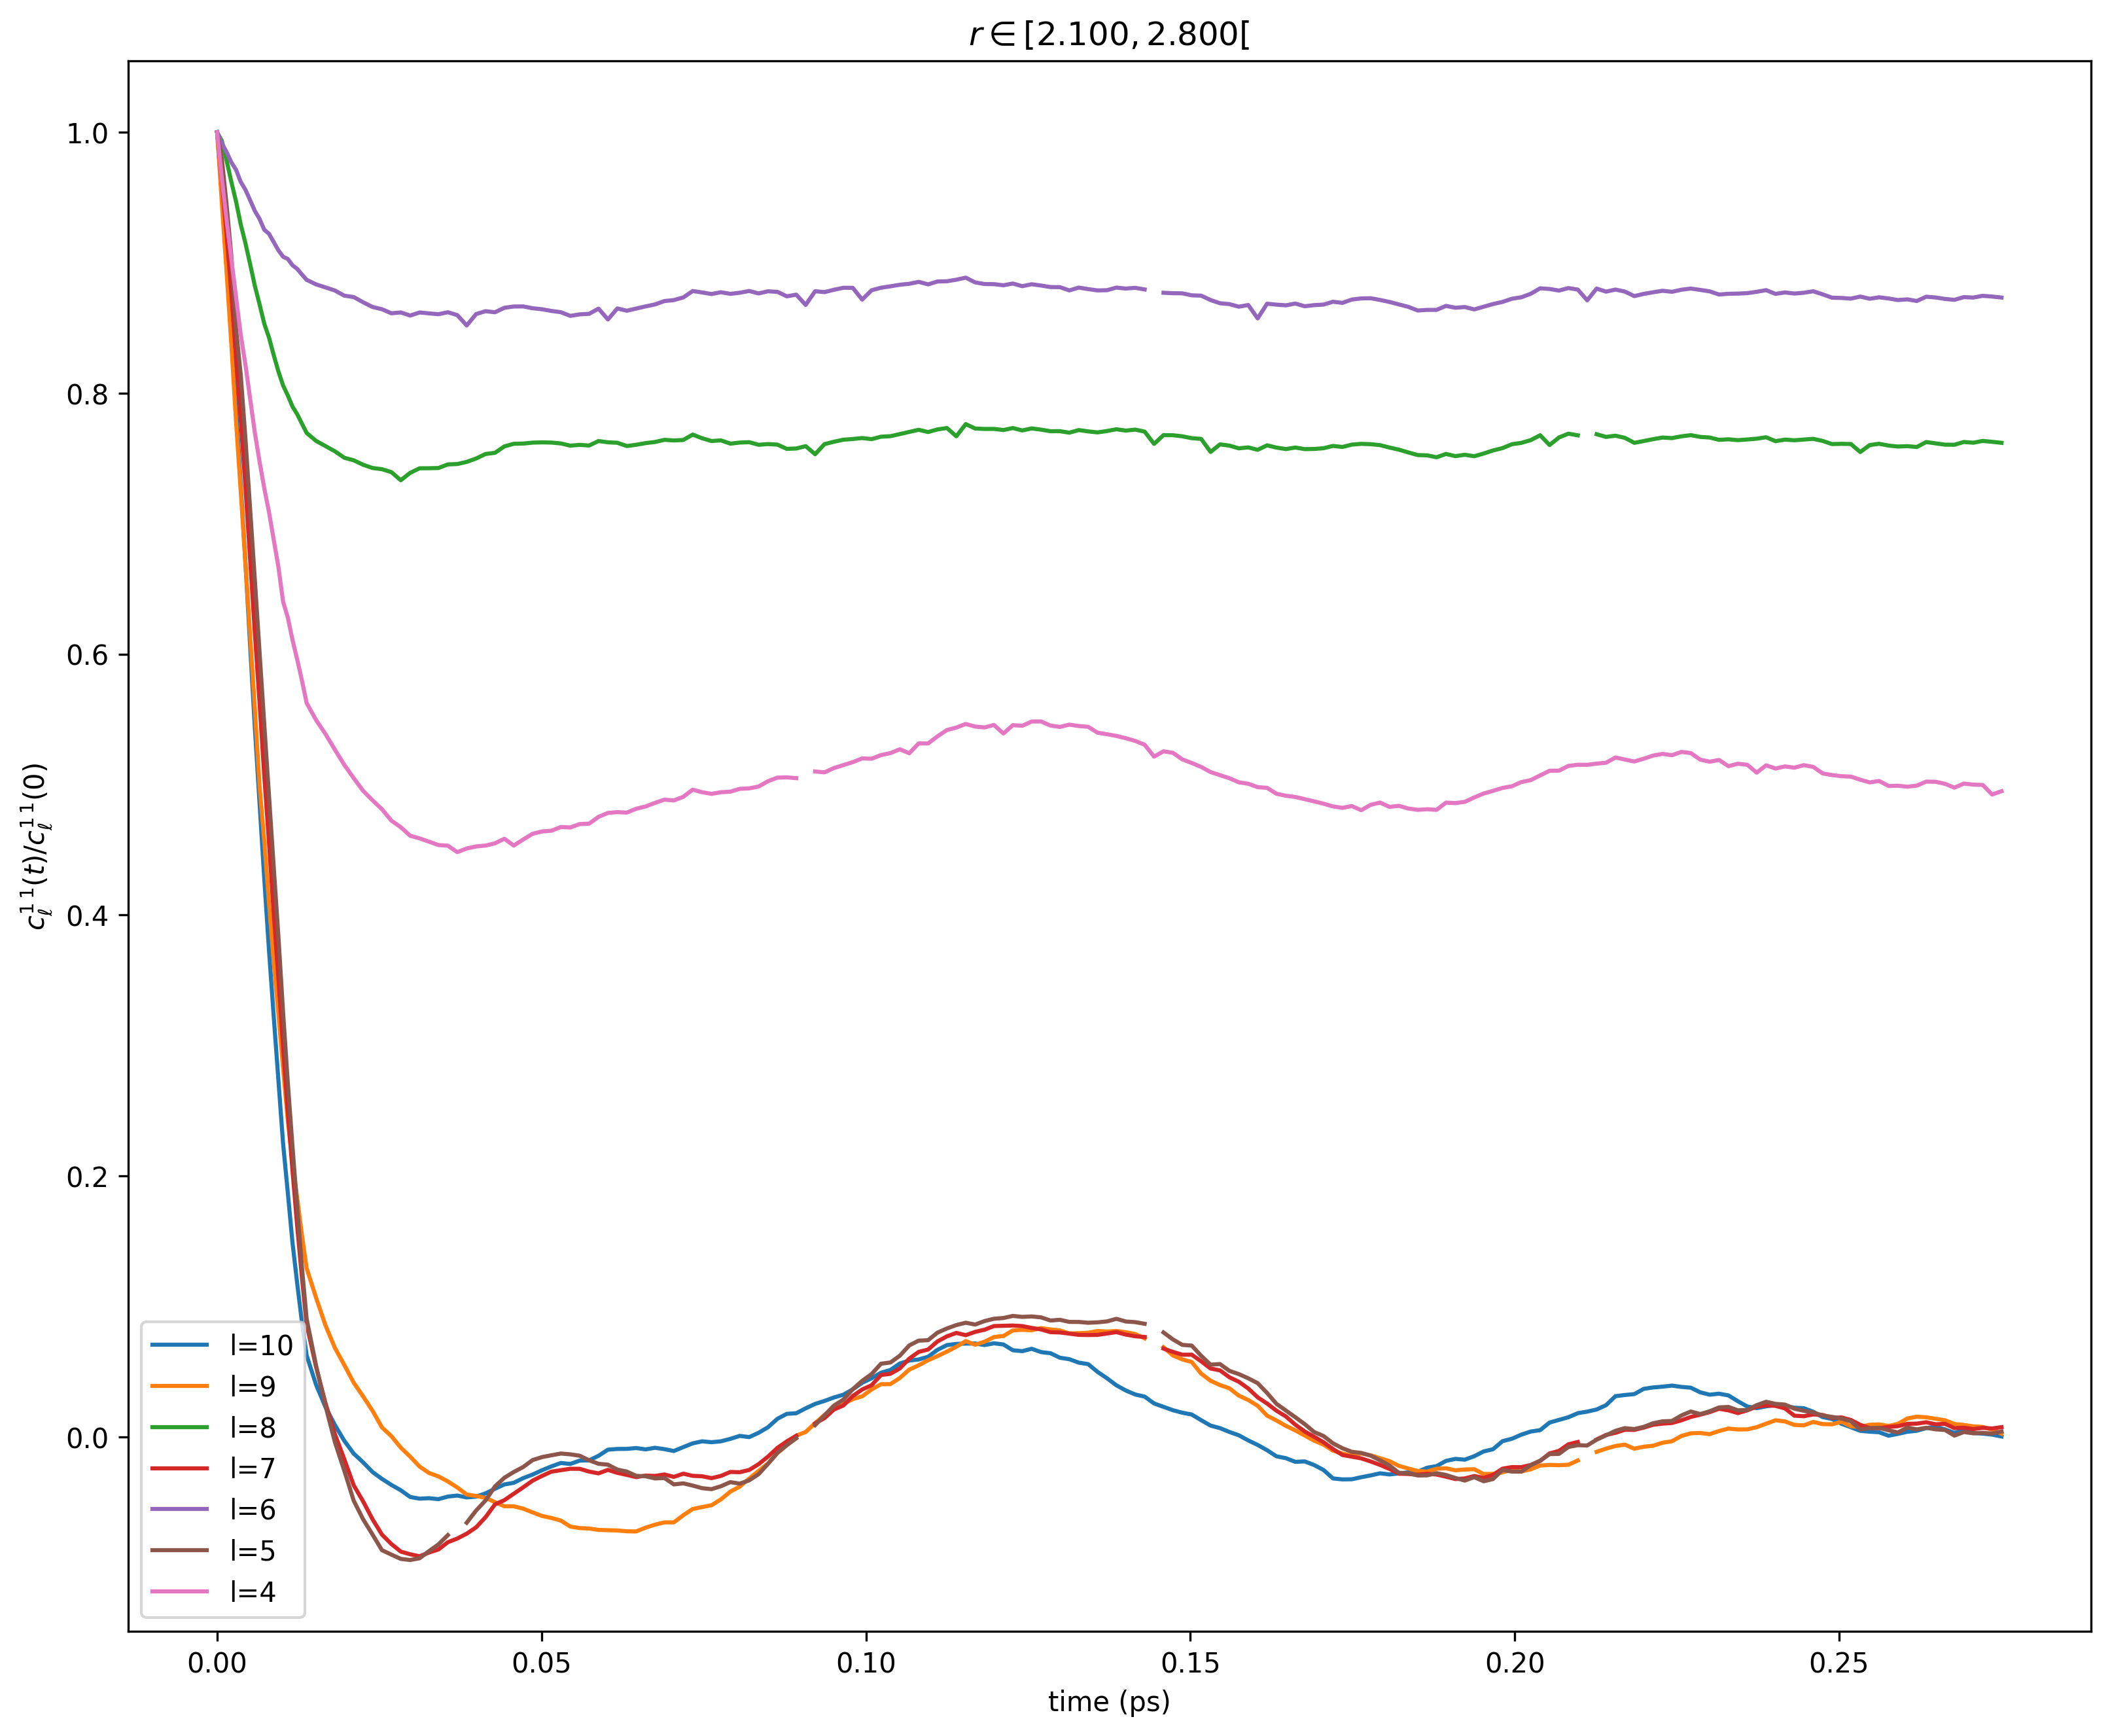

In [119]:
plot(1,1,2,0,7)

N-H correlations

l=5: 1.5454779754366799
l=4: 2.437079278872114
l=3: 2.8320750678422137
l=2: 0.3889389191844724
l=1: 0.27541924622459724
l=0: 0.7643180280925702
l=5: 3.444021831586772
l=4: 2.3469821194362614
l=3: 1.5428046418417072
l=2: 1.1253201752703885
l=1: 0.8788985677245273
l=0: 1.6144689733036435


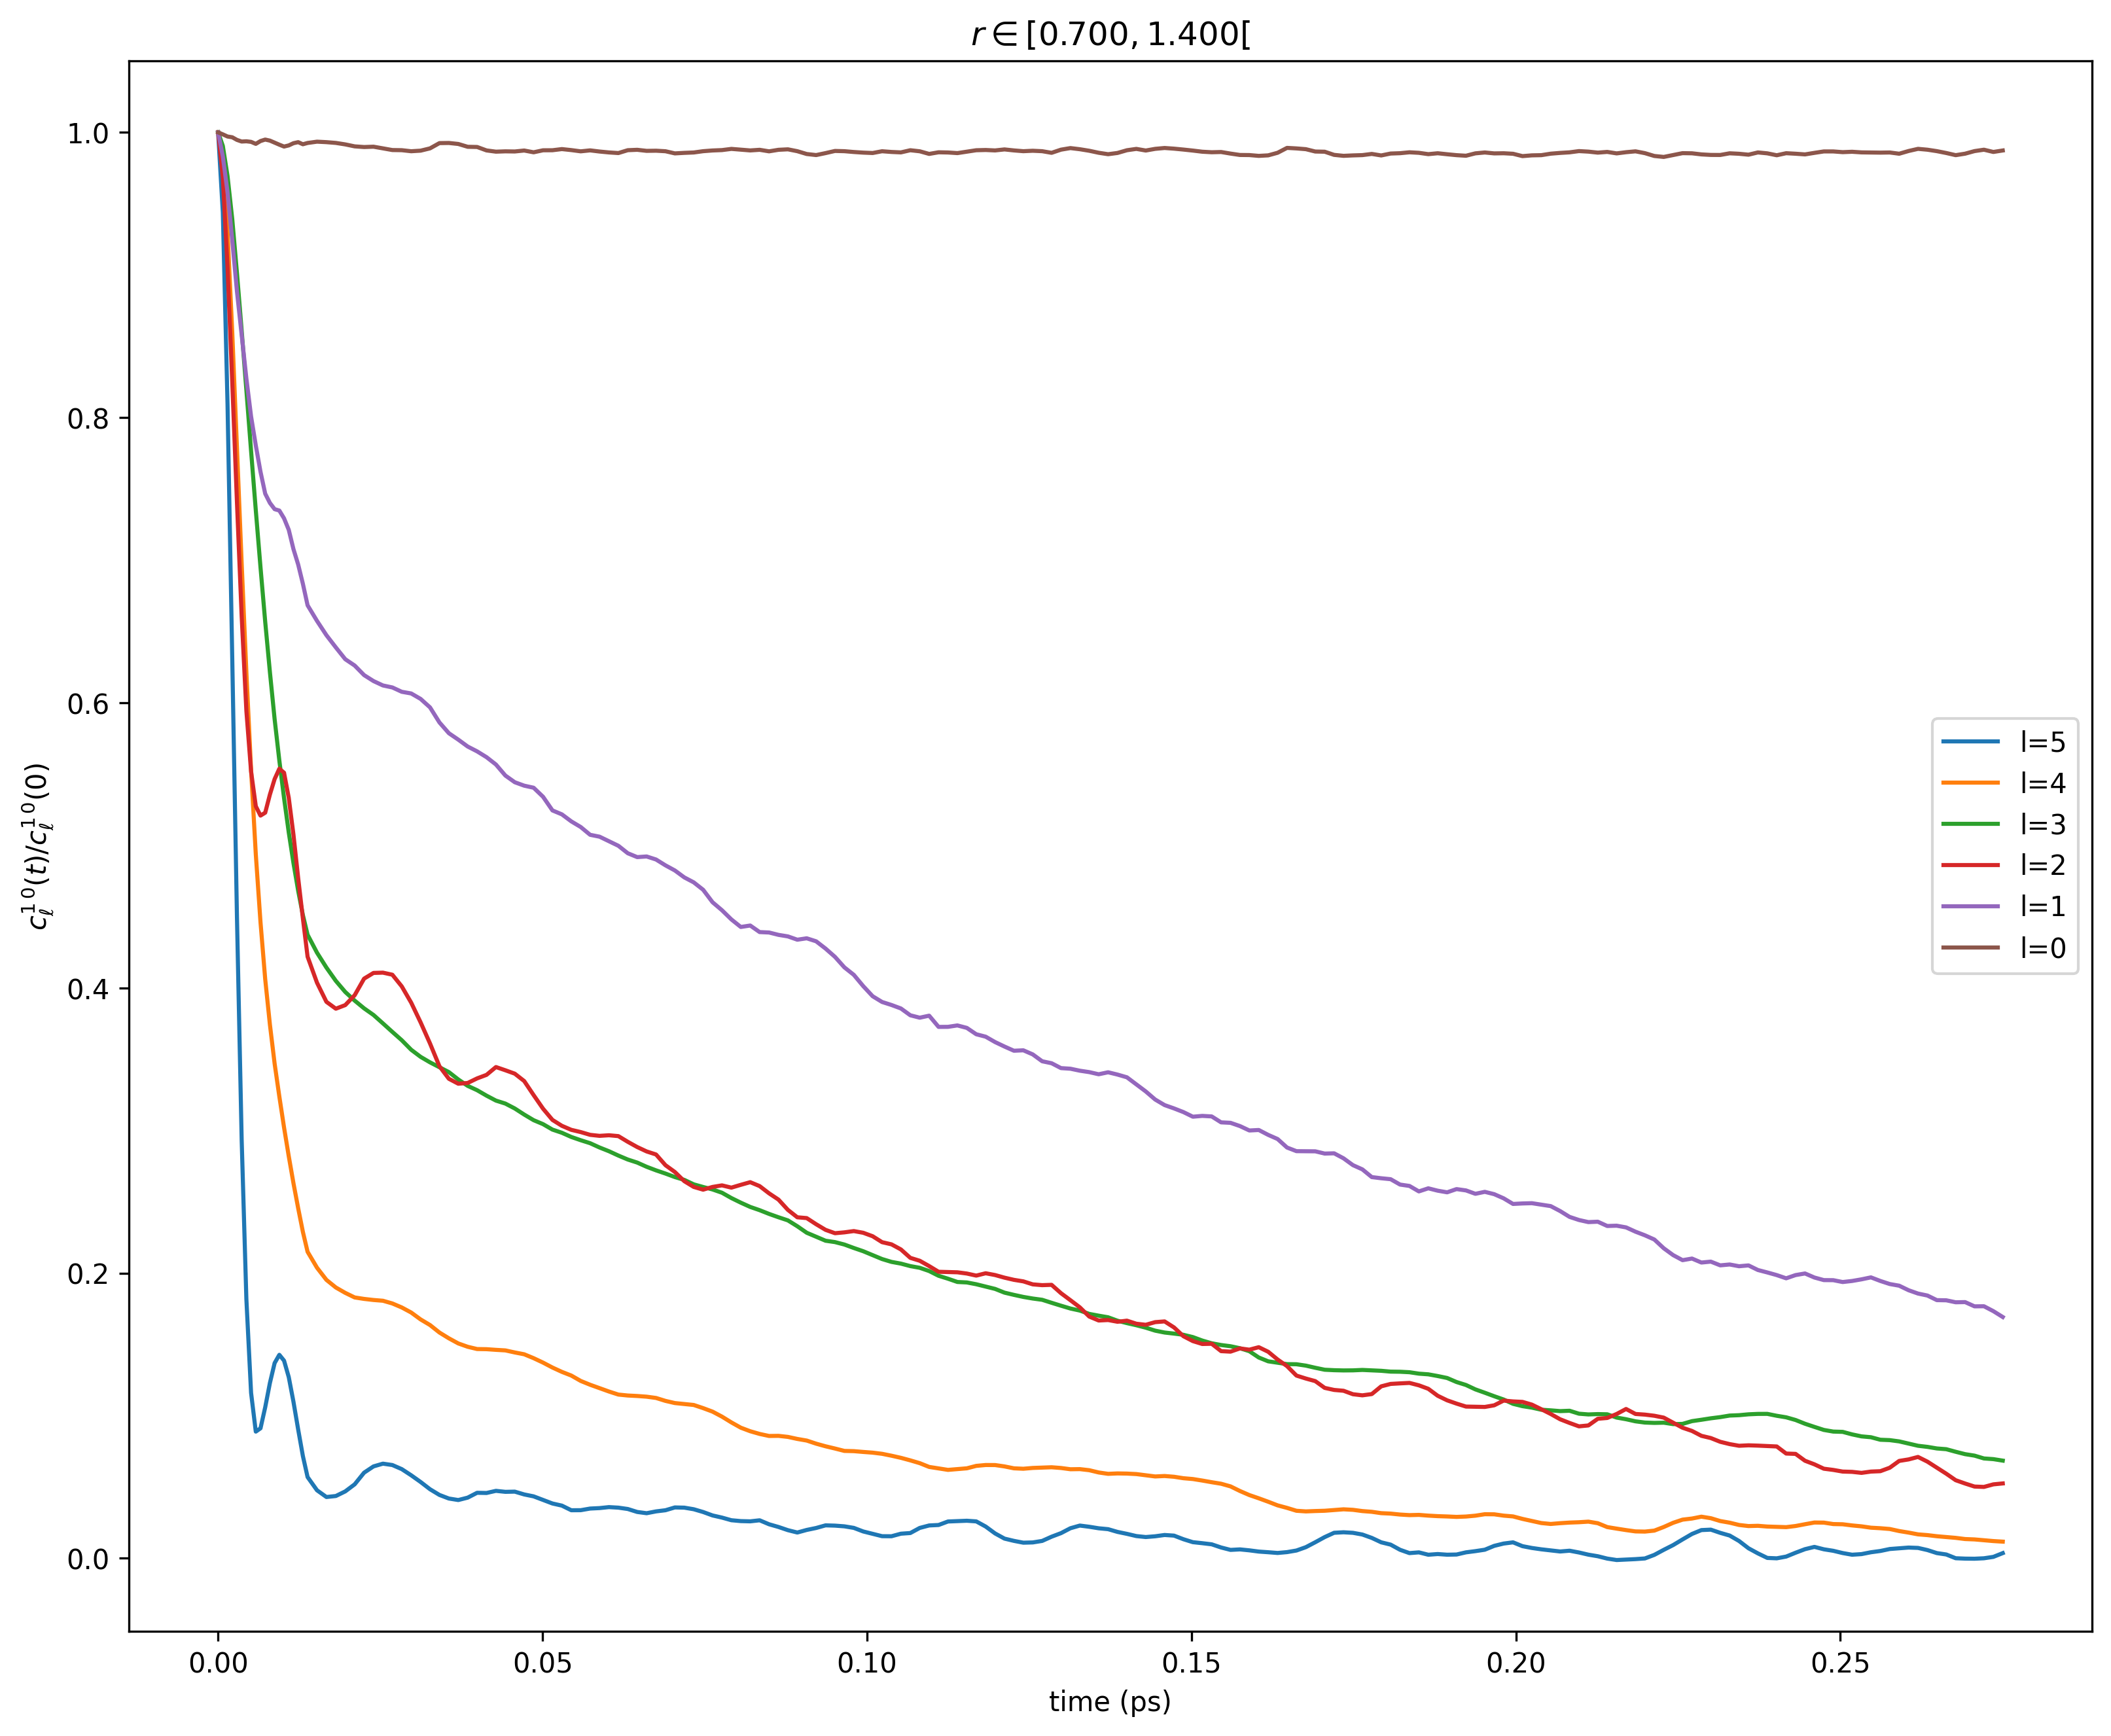

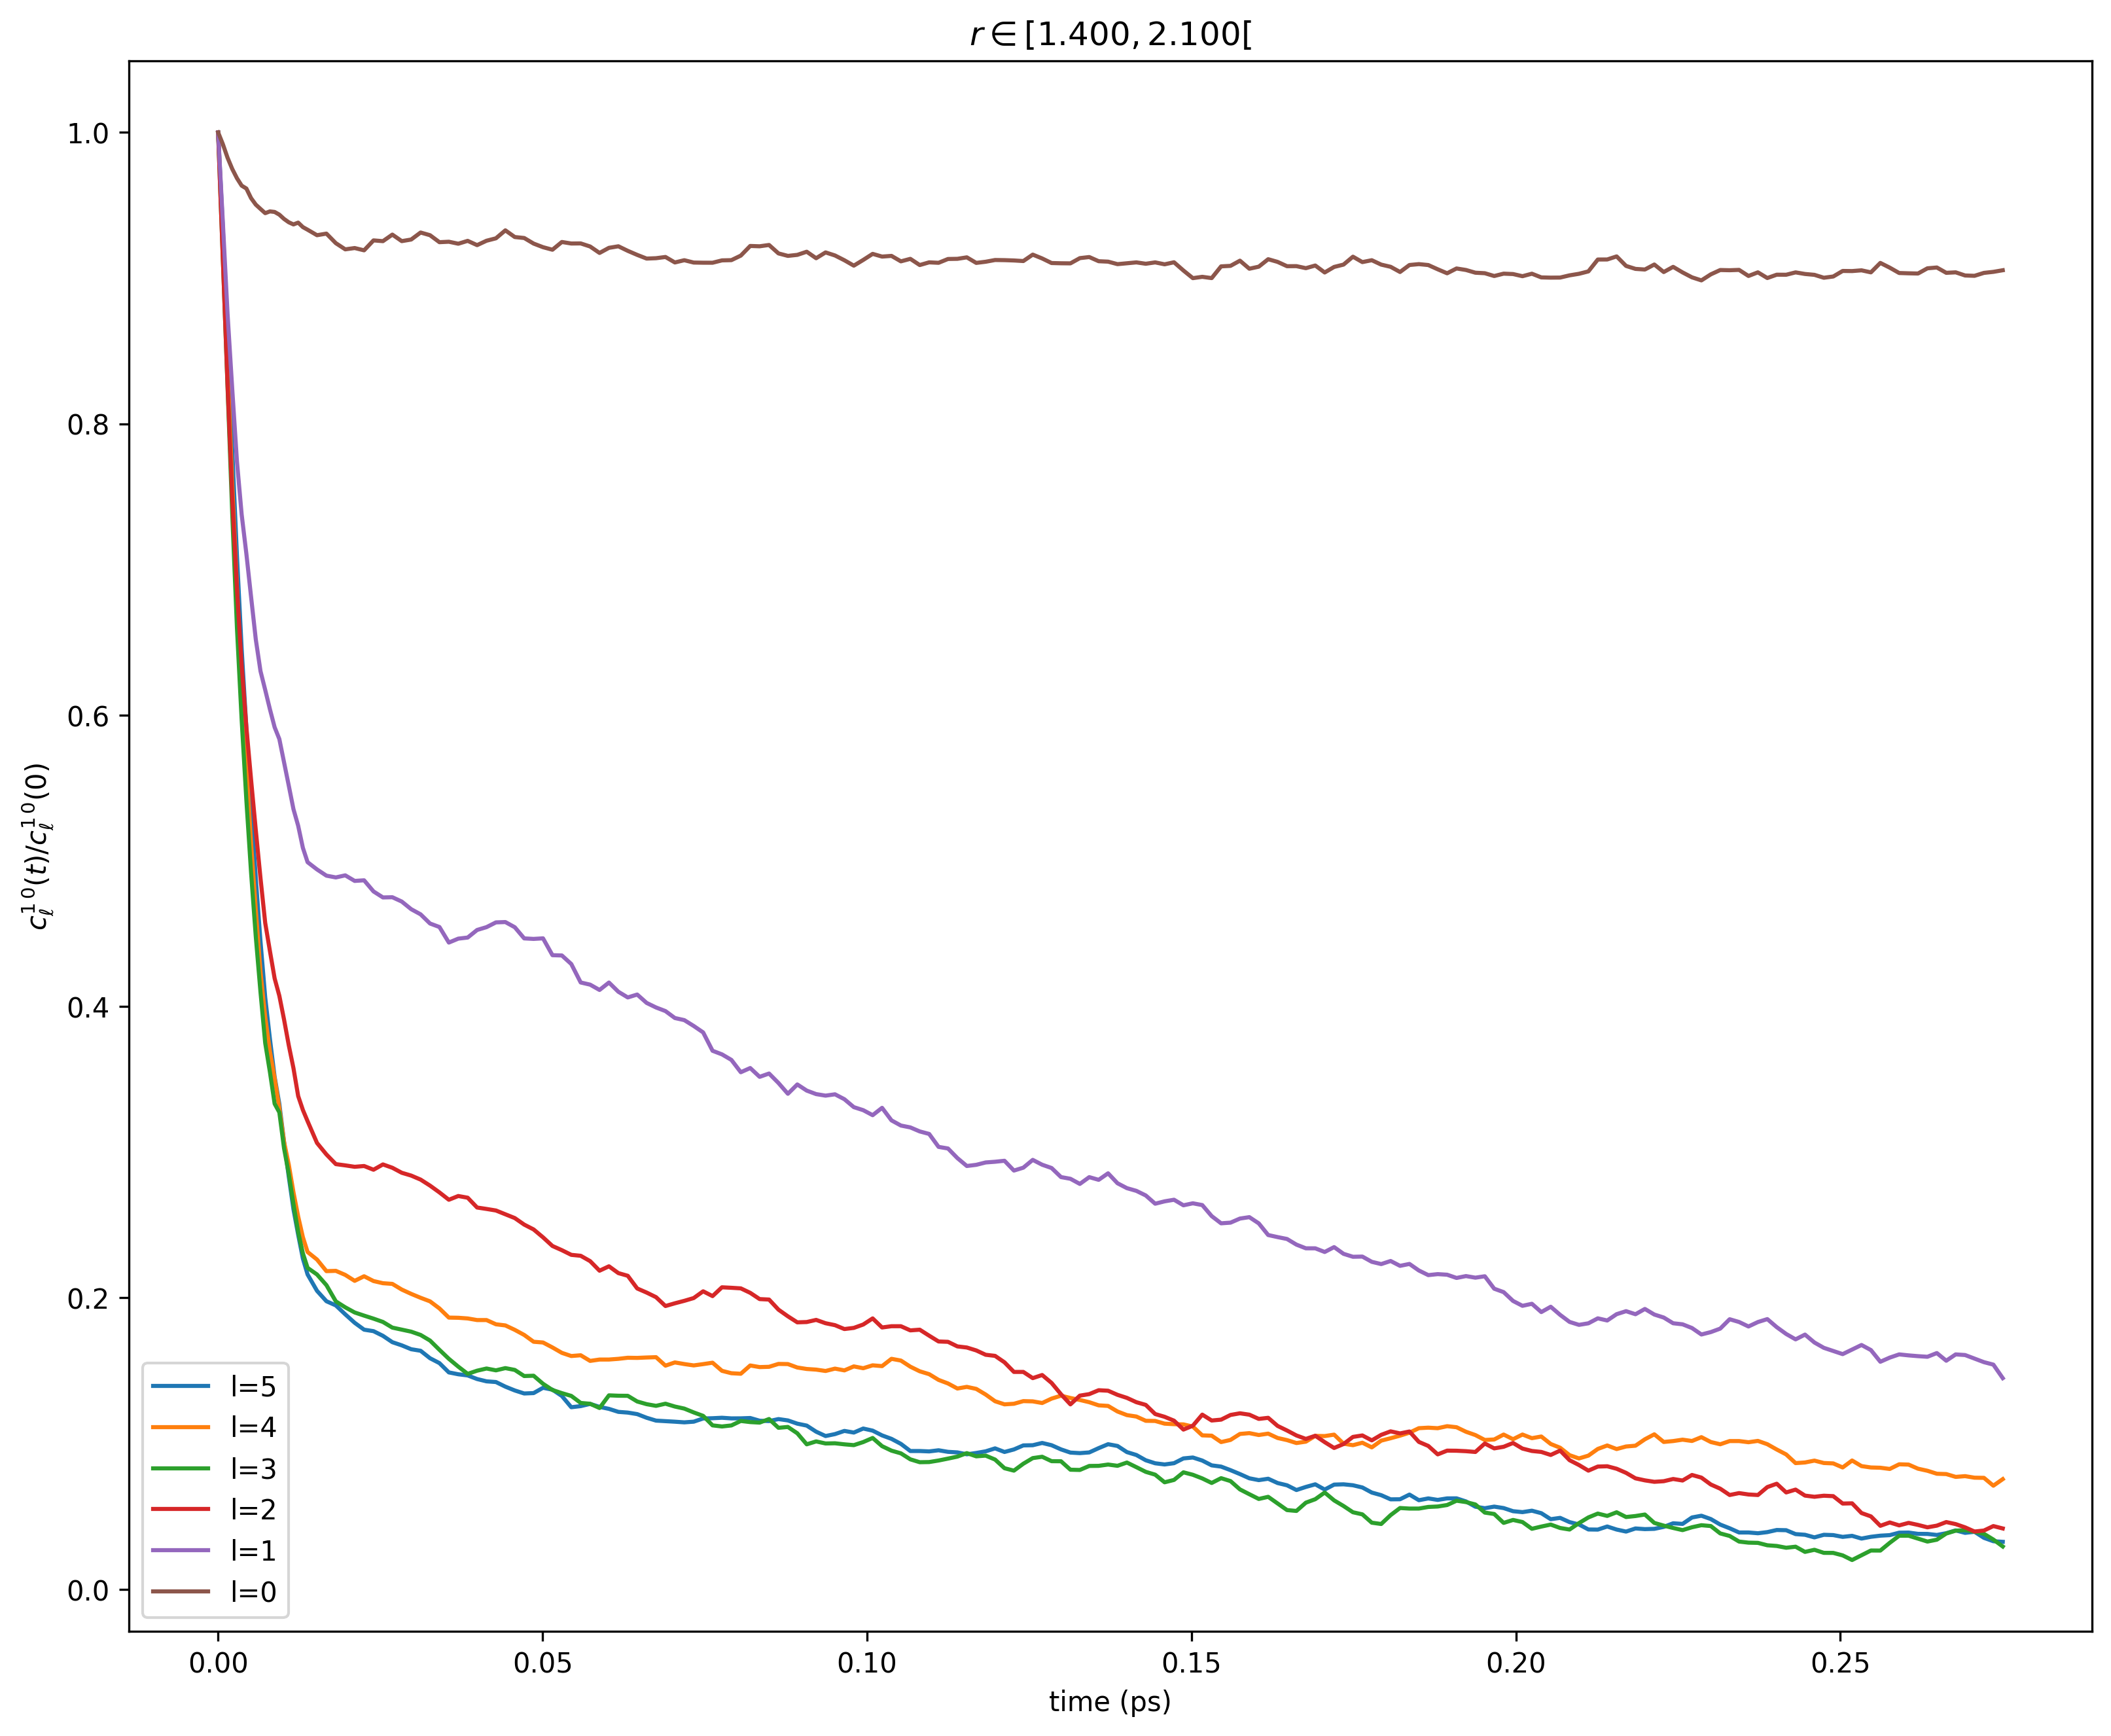

In [120]:
plot(1,0,0,5,11)
plot(1,0,1,5,11)

In [72]:

times = np.load(filepath_tests + '/data_NH3/times.npy')    

In [ ]:
pyanalisi.MeanSquareDisplacement(traj,)